# 1. Introduction

# 2. Import Libraries

In [ ]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, GRU, Dropout, Reshape, SimpleRNN
from tensorflow.keras.models import Sequential


nltk.download('stopwords')
nltk.download('punkt')

import pickle

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#--------------------------------------
# For load data in drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 3. Data Loading

In [ ]:
# Data Loading
df_ori = pd.read_csv('/content/drive/MyDrive/review_dana_labelled.csv')

# Variabel untuk dataset
df = df_ori.copy()

# Show top 5 data
df.head()

,userName,score,at,content,sentimen
0,Elisya Kasni,5,2024-02-15 11:24:56,Bagus,POSITIVE
1,Rusman Man,2,2024-02-15 11:24:03,Dana mmg keren mantap.,POSITIVE
2,Qiliw Sadega,1,2024-02-15 11:23:34,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kijutjrv2 Kijut,3,2024-02-15 11:22:46,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Fifi Alfiyah,1,2024-02-15 11:21:34,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  50000 non-null  object
 1   score     50000 non-null  int64 
 2   at        50000 non-null  object
 3   content   50000 non-null  object
 4   sentimen  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [ ]:
df.isna().sum()

userName    0
score       0
at          0
content     0
sentimen    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

## 3.1 Drop Unused Column

In [ ]:
# Drop Unused Columns
df = df.drop(['userName','at','score'],axis=1)

# Check data
df.head()

,content,sentimen
0,Bagus,POSITIVE
1,Dana mmg keren mantap.,POSITIVE
2,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE


## 3.2 Filter Data

In [ ]:
# Filter 3000 Data
df = df[:3000]

# Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   content   3000 non-null   object
 1   sentimen  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


# 4. EDA

## 4.1 Sentiment

In [ ]:
# Check Distribution of Dataset
df.sentimen.value_counts()

POSITIVE    1457
NEGATIVE    1118
NEUTRAL      425
Name: sentimen, dtype: int64

In [ ]:
target = df['sentimen'].value_counts().to_frame(name='count')
target['percentage'] = df['sentimen'].value_counts(normalize=True)
target.reset_index(inplace=True)
target

,index,count,percentage
0,POSITIVE,1457,0.485667
1,NEGATIVE,1118,0.372667
2,NEUTRAL,425,0.141667


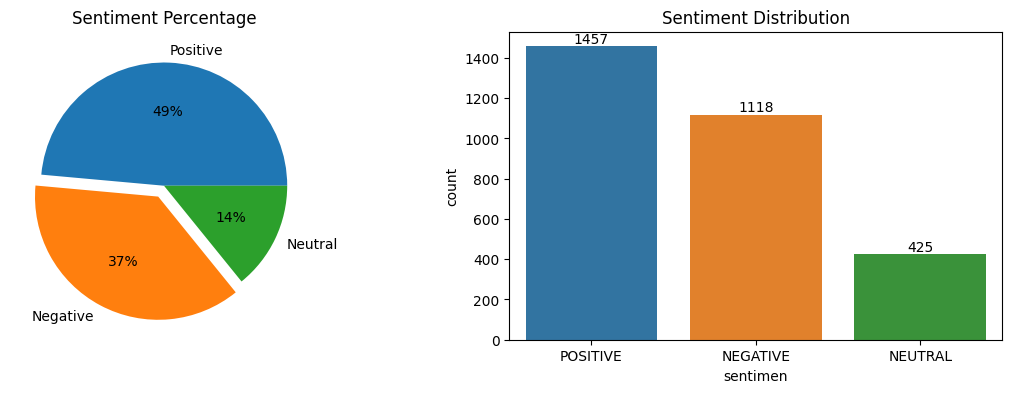

In [ ]:
# Visualization
plt.figure(figsize=(14, 4))

# Pie Chart
plt.subplot(1,2,1)
plt.title('Sentiment Percentage')
explode = [0,0.1,0]
labels = ['Positive','Negative', 'Neutral']
plt.pie(target["percentage"], labels=labels,explode=explode, autopct='%.0f%%')

# Barplot
plt.subplot(1,2,2)
plt.title('Sentiment Distribution')
ax = sns.countplot(data=df, x='sentimen', hue='sentimen')
for i in ax.containers:
    ax.bar_label(i,)

plt.show()

## 4.2 Sentiment Characteristics

## 4.2.1 Positive

In [ ]:
# Show Sentiment Positive
df[df['sentimen']=='POSITIVE']

,content,sentimen
0,Bagus,POSITIVE
1,Dana mmg keren mantap.,POSITIVE
5,mayan,POSITIVE
7,baik,POSITIVE
9,mempermudah transfer,POSITIVE
...,...,...
2985,gas,POSITIVE
2987,Sangat membantu,POSITIVE
2990,mantap,POSITIVE
2991,sangat puas,POSITIVE


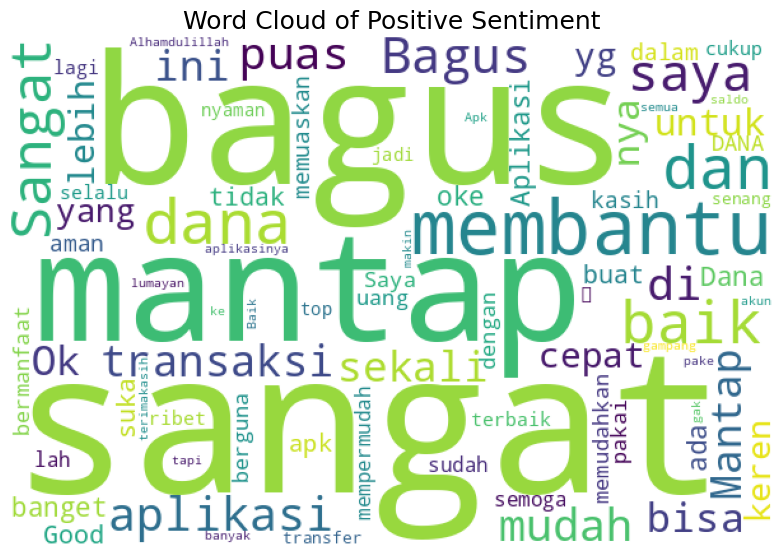

In [ ]:
# Filter kalimat dengan sentimen positif
positive_tweets = df[df['sentimen'] == 'POSITIVE']['content']

# Menghitung frekuensi kata
word_counts = Counter()
for tweet in positive_tweets:
    words = tweet.split()
    word_counts.update(words)

# Mengurutkan kata berdasarkan frekuensi
most_common_words = word_counts.most_common()

# Membuat word cloud
wordcloud = WordCloud(width = 600, height = 400, background_color = 'white', min_font_size = 10).generate_from_frequencies(dict(most_common_words))
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Positive Sentiment', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## 4.2.2 Neutral

In [ ]:
# Show Sentiment Neutral
df[df['sentimen']=='NEUTRAL']

,content,sentimen
8,TOLONG UNTUK SISTEM KEAMANAN DI PERBAIKI. KALA...,NEUTRAL
10,baru yobain semoga aman sentosa tidak pembobol...,NEUTRAL
23,Aplikasi taiiiiiii upgrade ke premium terlalu ...,NEUTRAL
24,Saldo Saya tiba tiba hilang sendiri ga aman na...,NEUTRAL
25,Susahh bgt buat masuk aja masak dh pakai 3nome...,NEUTRAL
...,...,...
2959,Saat login kode verifikasinya tidak muncu,NEUTRAL
2969,Kenapah dana klo login keluwar terus,NEUTRAL
2986,Saya dh MLS aplikasi dana ribed,NEUTRAL
2994,ALHAMDULILLAH AMIN 01 MENANG,NEUTRAL


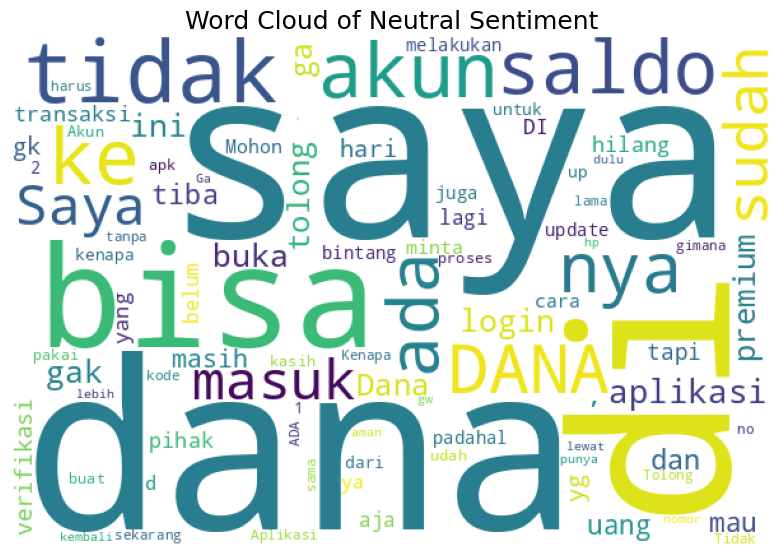

In [ ]:
# Filter kalimat dengan sentimen neutral
positive_tweets = df[df['sentimen'] == 'NEUTRAL']['content']

# Menghitung frekuensi kata
word_counts = Counter()
for tweet in positive_tweets:
    words = tweet.split()
    word_counts.update(words)

# Mengurutkan kata berdasarkan frekuensi
most_common_words = word_counts.most_common()

# Membuat word cloud
wordcloud = WordCloud(width = 600, height = 400, background_color = 'white', min_font_size = 10).generate_from_frequencies(dict(most_common_words))
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Neutral Sentiment', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

## 4.2.3 Negative

In [ ]:
# Show Sentiment NEGATIVE
df[df['sentimen']=='NEGATIVE']

,content,sentimen
2,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE
3,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE
4,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE
6,Udah gua hapus dana ya. ilang ya udah 1 juta l...,NEGATIVE
11,kok gx bisa keridit,NEGATIVE
...,...,...
2992,menggapa bahasa Inggris,NEGATIVE
2993,ok,NEGATIVE
2995,ok,NEGATIVE
2996,Apk taiii masa lihat bukti tf aja susah kebuka,NEGATIVE


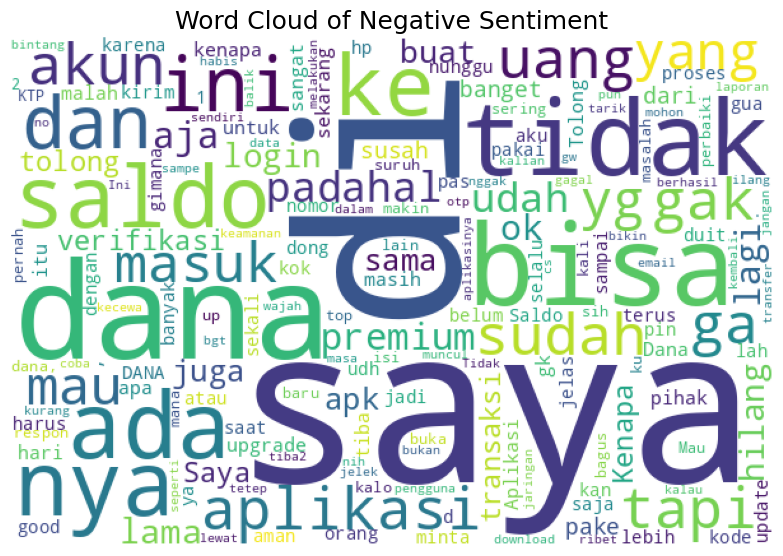

In [ ]:
# Filter kalimat dengan sentimen negatif
positive_tweets = df[df['sentimen'] == 'NEGATIVE']['content']

# Menghitung frekuensi kata
word_counts = Counter()
for tweet in positive_tweets:
    words = tweet.split()
    word_counts.update(words)

# Mengurutkan kata berdasarkan frekuensi
most_common_words = word_counts.most_common()

# Membuat word cloud
wordcloud = WordCloud(width = 600, height = 400, background_color = 'white', min_font_size = 10).generate_from_frequencies(dict(most_common_words))
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Negative Sentiment', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

# 5. Feature Engineering

## 5.1 Text Preprocessing

In [ ]:
# Define Stopwords
from nltk.corpus import stopwords
stpwds_id = list(set(stopwords.words('indonesian')))
new_word = ['ko','gk','yg','bos','buat','ya','ga','ini','juga',
            'sangat','buat','tanpa','lebih','pakai','bagi','apk',
            'terima kasih','masokkkkk','nya','gak','dana','aplikasi']
stpwds_id.extend(new_word)

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

In [ ]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Symbol removal
  text = re.sub("^!-.ðŸ‘¡,âœŒï˜£ð˜¨ð˜¶Â²?/¢+™'", " ", text)

  # Symbol removal
  text = re.sub("!-.ðŸ‘¡,âœŒï˜£ð˜¨ð˜¶Â²?/¢+™'\s*$", " ", text)

  # Number Removal
  text = re.sub(r"[0-9]", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [ ]:
# Applying Text Preprocessing to the Dataset
df['review'] = df['content'].apply(lambda x: text_preprocessing(x))
df

,content,sentimen,review
0,Bagus,POSITIVE,bagus
1,Dana mmg keren mantap.,POSITIVE,mmg keren mantap
2,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE,ngajuin upgrade premium krna ktp buram jdi ver...
3,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE,kocak diskon ml eror kaga ikhlas ngasih diskon
4,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE,saldo hilang no hilang ganti no saldo tanggung...
...,...,...,...
2995,ok,NEGATIVE,ok
2996,Apk taiii masa lihat bukti tf aja susah kebuka,NEGATIVE,taiii lihat bukti tf aja susah buka
2997,harus nunggu berapa lagi untuk bisa menggunaka...,NEUTRAL,nunggu premium proses data mulu kerja hari
2998,"Gampang di retas,buat yg pakai aplikasi dana,h...",NEGATIVE,gampang retas hati akun rawan gampang retas pt...


## 5.2 Target Conversion

In [ ]:
# Display Target
df.sentimen.unique()

array(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], dtype=object)

In [ ]:
# Change Target into Number
df['label'] = df['sentimen'].replace({'NEGATIVE' : 0, 'NEUTRAL' : 1, 'POSITIVE' : 2})
df

,content,sentimen,review,label
0,Bagus,POSITIVE,bagus,2
1,Dana mmg keren mantap.,POSITIVE,mmg keren mantap,2
2,Saya ngajuin upgrade dana premium krna ktp say...,NEGATIVE,ngajuin upgrade premium krna ktp buram jdi ver...,0
3,Kocak mana diskon nya ml malah eror segala kag...,NEGATIVE,kocak diskon ml eror kaga ikhlas ngasih diskon,0
4,Saldo hilang karena no lama Hilang ganti no sa...,NEGATIVE,saldo hilang no hilang ganti no saldo tanggung...,0
...,...,...,...,...
2995,ok,NEGATIVE,ok,0
2996,Apk taiii masa lihat bukti tf aja susah kebuka,NEGATIVE,taiii lihat bukti tf aja susah buka,0
2997,harus nunggu berapa lagi untuk bisa menggunaka...,NEUTRAL,nunggu premium proses data mulu kerja hari,1
2998,"Gampang di retas,buat yg pakai aplikasi dana,h...",NEGATIVE,gampang retas hati akun rawan gampang retas pt...,0


## 5.3 Split Feature, Target, Train and Test Set

For this task, we only need column `CONTENT` as corpus and column `CLASS` as target.

In [ ]:
# Splitting Dataset

X_train, X_test, y_train, y_test = train_test_split(df['review'],
                                                    df.label,
                                                    test_size=0.2,
                                                    random_state=6)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  stratify=y_train)

print('Train Size : ', len(X_train))
print('Val Size   : ', len(X_val))
print('Test Size  : ', len(X_test))

Train Size :  2160
Val Size   :  240
Test Size  :  600


## 5.4 Feature Encoding

In [ ]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

# 6. ANN Training

## 6.1 Model Building

### 6.1.1 - Text Vectorization

In [ ]:
# Get Vocabularies

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<2160x2216 sparse matrix of type '<class 'numpy.int64'>'
	with 9758 stored elements in Compressed Sparse Row format>

In [ ]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  2216
Maximum Sentence Length :  56 tokens


In [ ]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

In [ ]:
# Example Result

## Document example
print('Document example')
print(df.review[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.review[0]]))
print('Vector size : ', text_vectorization([df.review[0]]).shape)

Document example
bagus

Result of Text Vectorization
tf.Tensor(
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 56), dtype=int64)
Vector size :  (1, 56)


In [ ]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'bagus',
 'saldo',
 'akun',
 'uang',
 'bantu',
 'masuk',
 'mantap',
 'tolong',
 'transaksi',
 'hilang',
 'premium',
 'mudah',
 'ok',
 'aja',
 'login',
 'udah',
 'verifikasi',
 'aman']

### 6.1.2 - Word Embedding

In [ ]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

In [ ]:
# Example Result

## Document example
print('Document example')
print(df.review[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.review[0]]))
print('Vector size : ', text_vectorization([df.review[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.review[0]])))
print('Vector size : ', embedding(text_vectorization([df.review[0]])).shape)

Document example
bagus

Result of  Text Vectorization
tf.Tensor(
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 56), dtype=int64)
Vector size :  (1, 56)

Result of  Embedding
tf.Tensor(
[[[ 0.00015683  0.02661499 -0.00343665 ... -0.04883669 -0.02124808
    0.00772456]
  [-0.01396685 -0.041453    0.0080879  ... -0.00396274  0.01181388
    0.01502799]
  [-0.01396685 -0.041453    0.0080879  ... -0.00396274  0.01181388
    0.01502799]
  ...
  [-0.01396685 -0.041453    0.0080879  ... -0.00396274  0.01181388
    0.01502799]
  [-0.01396685 -0.041453    0.0080879  ... -0.00396274  0.01181388
    0.01502799]
  [-0.01396685 -0.041453    0.0080879  ... -0.00396274  0.01181388
    0.01502799]]], shape=(1, 56, 128), dtype=float32)
Vector size :  (1, 56, 128)


### 6.1.3 - LSTM

In [ ]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

CPU times: user 1.06 s, sys: 32.1 ms, total: 1.09 s
Wall time: 1.14 s


In [ ]:
%%time
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 15s 105ms/step - loss: 0.9012 - accuracy: 0.6000 - val_loss: 0.7125 - val_accuracy: 0.7042
Epoch 2/25
68/68 [==============================] - 3s 52ms/step - loss: 0.6190 - accuracy: 0.7514 - val_loss: 0.5802 - val_accuracy: 0.7833
Epoch 3/25
68/68 [==============================] - 3s 46ms/step - loss: 0.5554 - accuracy: 0.7727 - val_loss: 0.6665 - val_accuracy: 0.7292
Epoch 4/25
68/68 [==============================] - 3s 37ms/step - loss: 0.5222 - accuracy: 0.7847 - val_loss: 0.6487 - val_accuracy: 0.7083
Epoch 5/25
68/68 [==============================] - 2s 28ms/step - loss: 0.4688 - accuracy: 0.8069 - val_loss: 0.6557 - val_accuracy: 0.7583
Epoch 6/25
68/68 [==============================] - 1s 17ms/step - loss: 0.3677 - accuracy: 0.8667 - val_loss: 0.7237 - val_accuracy: 0.7375
Epoch 7/25
68/68 [==============================] - 2s 23ms/step - loss: 0.3014 - accuracy: 0.8991 - val_loss: 0.8337 - val_accuracy: 0.7375
Epoch 8/25


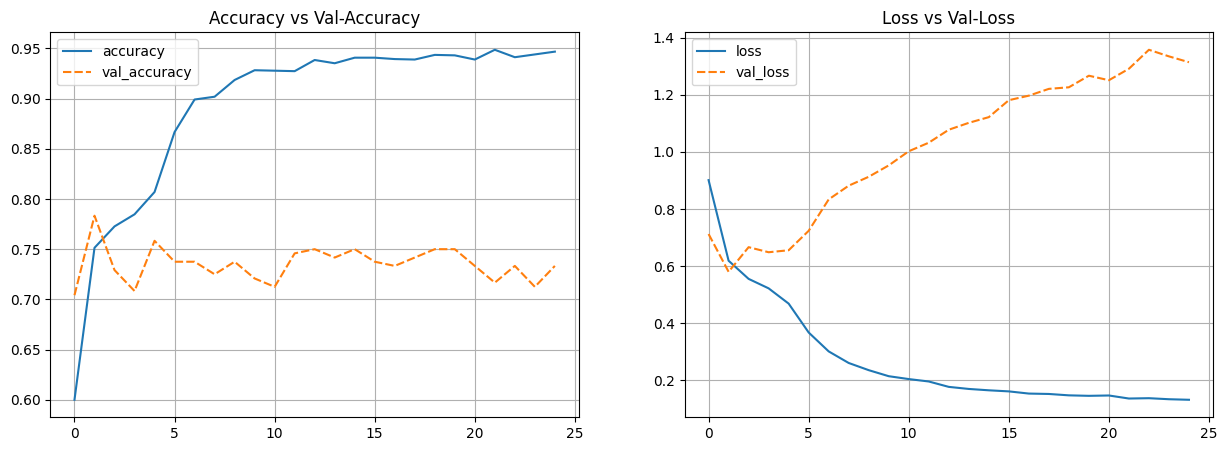

In [ ]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
y_test.unique()

array([0, 2, 1])

In [ ]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_lstm_1.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.69      0.84      0.76       234
           1       0.53      0.24      0.33        88
           2       0.85      0.85      0.85       278

    accuracy                           0.75       600
   macro avg       0.69      0.64      0.64       600
weighted avg       0.74      0.75      0.74       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.

### 6.1.3 - GRU

In [ ]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_gru = Sequential()
model_gru.add(text_vectorization)
model_gru.add(embedding)
model_gru.add(Bidirectional(GRU(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.1))
model_gru.add(Bidirectional(GRU(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_gru.add(Dropout(0.1))
model_gru.add(Dense(3, activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics='accuracy')

CPU times: user 918 ms, sys: 6 ms, total: 924 ms
Wall time: 914 ms


In [ ]:
%%time
model_gru_hist = model_gru.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 17s 110ms/step - loss: 0.6596 - accuracy: 0.7727 - val_loss: 0.6205 - val_accuracy: 0.7583
Epoch 2/25
68/68 [==============================] - 5s 81ms/step - loss: 0.2534 - accuracy: 0.9157 - val_loss: 0.8318 - val_accuracy: 0.7750
Epoch 3/25
68/68 [==============================] - 4s 55ms/step - loss: 0.1764 - accuracy: 0.9333 - val_loss: 0.9360 - val_accuracy: 0.7458
Epoch 4/25
68/68 [==============================] - 2s 32ms/step - loss: 0.1604 - accuracy: 0.9352 - val_loss: 0.9895 - val_accuracy: 0.7500
Epoch 5/25
68/68 [==============================] - 2s 35ms/step - loss: 0.1499 - accuracy: 0.9389 - val_loss: 1.0175 - val_accuracy: 0.7417
Epoch 6/25
68/68 [==============================] - 2s 25ms/step - loss: 0.1408 - accuracy: 0.9454 - val_loss: 1.0643 - val_accuracy: 0.7583
Epoch 7/25
68/68 [==============================] - 2s 31ms/step - loss: 0.1367 - accuracy: 0.9463 - val_loss: 1.0927 - val_accuracy: 0.7500
Epoch 8/25


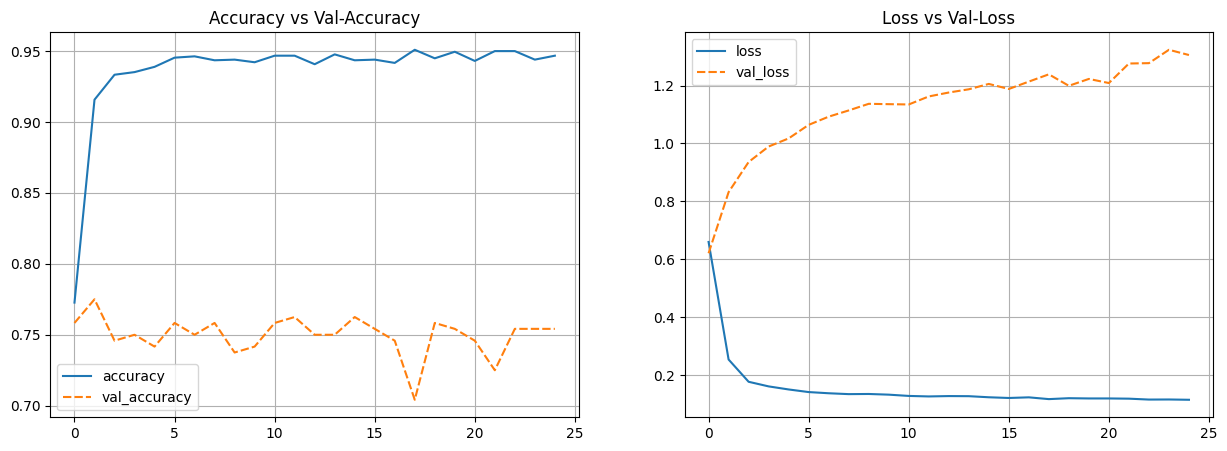

In [ ]:
# Plot Training Results

model_gru_hist_df = pd.DataFrame(model_gru_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_gru.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.74      0.82      0.77       234
           1       0.51      0.25      0.34        88
           2       0.85      0.91      0.88       278

    accuracy                           0.78       600
   macro avg       0.70      0.66      0.66       600
weighted avg       0.75      0.78      0.76       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.

### 6.1.3 - RNN

In [ ]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_rnn = Sequential()
model_rnn.add(text_vectorization)
model_rnn.add(embedding)
model_rnn.add(SimpleRNN(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_rnn.add(Dropout(0.1))
model_rnn.add(SimpleRNN(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed)))
model_rnn.add(Dropout(0.1))
model_rnn.add(Dense(3, activation='softmax'))

model_rnn.compile(loss='categorical_crossentropy', optimizer='AdaMax', metrics='accuracy')

CPU times: user 318 ms, sys: 3.71 ms, total: 322 ms
Wall time: 1.15 s


In [ ]:
%%time
model_rnn_hist = model_rnn.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 35s 435ms/step - loss: 0.7362 - accuracy: 0.7023 - val_loss: 0.7817 - val_accuracy: 0.6833
Epoch 2/25
68/68 [==============================] - 8s 123ms/step - loss: 0.4994 - accuracy: 0.8287 - val_loss: 0.7914 - val_accuracy: 0.7125
Epoch 3/25
68/68 [==============================] - 9s 139ms/step - loss: 0.3852 - accuracy: 0.8667 - val_loss: 0.8111 - val_accuracy: 0.7083
Epoch 4/25
68/68 [==============================] - 9s 130ms/step - loss: 0.3132 - accuracy: 0.9009 - val_loss: 0.8909 - val_accuracy: 0.6958
Epoch 5/25
68/68 [==============================] - 7s 105ms/step - loss: 0.2768 - accuracy: 0.9037 - val_loss: 0.9245 - val_accuracy: 0.6917
Epoch 6/25
68/68 [==============================] - 8s 119ms/step - loss: 0.2407 - accuracy: 0.9190 - val_loss: 0.9365 - val_accuracy: 0.7083
Epoch 7/25
68/68 [==============================] - 7s 100ms/step - loss: 0.2209 - accuracy: 0.9255 - val_loss: 0.9361 - val_accuracy: 0.7250
Epoch

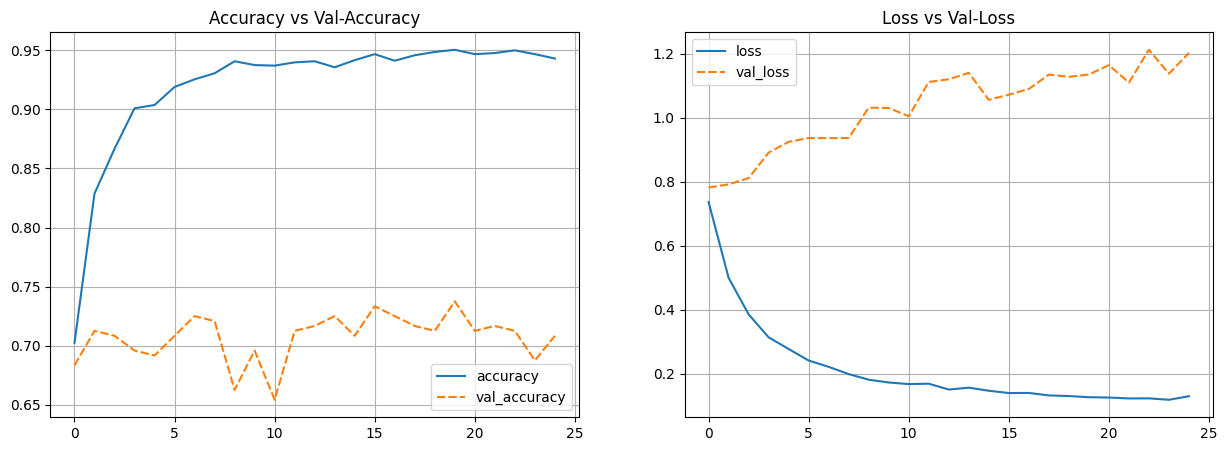

In [ ]:
# Plot Training Results

model_rnn_hist_df = pd.DataFrame(model_rnn_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_rnn_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_rnn_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_rnn.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       234
           1       0.44      0.16      0.23        88
           2       0.80      0.83      0.81       278

    accuracy                           0.72       600
   macro avg       0.63      0.59      0.59       600
weighted avg       0.69      0.72      0.69       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.

### 6.1.4 - LSTM with Transfer Learning

Let's improve our model using transfer learning. We will use embedding layer that was trained on Google news 3B corpus.

For more details please visit :
* [Embedding layer source](https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1)
* [List of Embedding Layers in Indonesian language](https://tfhub.dev/s?module-type=text-embedding&q=indonesian)

In [ ]:
# Download the Embedding Layer

url = 'https://tfhub.dev/google/tf2-preview/nnlm-id-dim128-with-normalization/1'

hub_layer = tf_hub.KerasLayer(url, output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Model Training using LSTM with Transfer Learning
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_2 = Sequential()
model_lstm_2.add(hub_layer)
model_lstm_2.add(Reshape((128, 1)))
model_lstm_2.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_2.add(Dropout(0.1))
model_lstm_2.add(Dense(3, activation='softmax'))

model_lstm_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_lstm_2_hist = model_lstm_2.fit(X_train, y_train_ohe, epochs=25, validation_data=(X_val, y_val_ohe))

Epoch 1/25
68/68 [==============================] - 10s 58ms/step - loss: 0.9970 - accuracy: 0.5125 - val_loss: 0.9326 - val_accuracy: 0.6000
Epoch 2/25
68/68 [==============================] - 2s 22ms/step - loss: 0.9123 - accuracy: 0.6153 - val_loss: 0.8435 - val_accuracy: 0.6958
Epoch 3/25
68/68 [==============================] - 1s 22ms/step - loss: 0.8420 - accuracy: 0.6574 - val_loss: 0.8565 - val_accuracy: 0.6292
Epoch 4/25
68/68 [==============================] - 1s 21ms/step - loss: 0.8350 - accuracy: 0.6602 - val_loss: 0.8172 - val_accuracy: 0.6667
Epoch 5/25
68/68 [==============================] - 1s 22ms/step - loss: 0.8186 - accuracy: 0.6602 - val_loss: 0.8066 - val_accuracy: 0.6708
Epoch 6/25
68/68 [==============================] - 1s 22ms/step - loss: 0.8265 - accuracy: 0.6602 - val_loss: 0.8195 - val_accuracy: 0.7042
Epoch 7/25
68/68 [==============================] - 2s 23ms/step - loss: 0.8143 - accuracy: 0.6667 - val_loss: 0.7959 - val_accuracy: 0.7125
Epoch 8/25
6

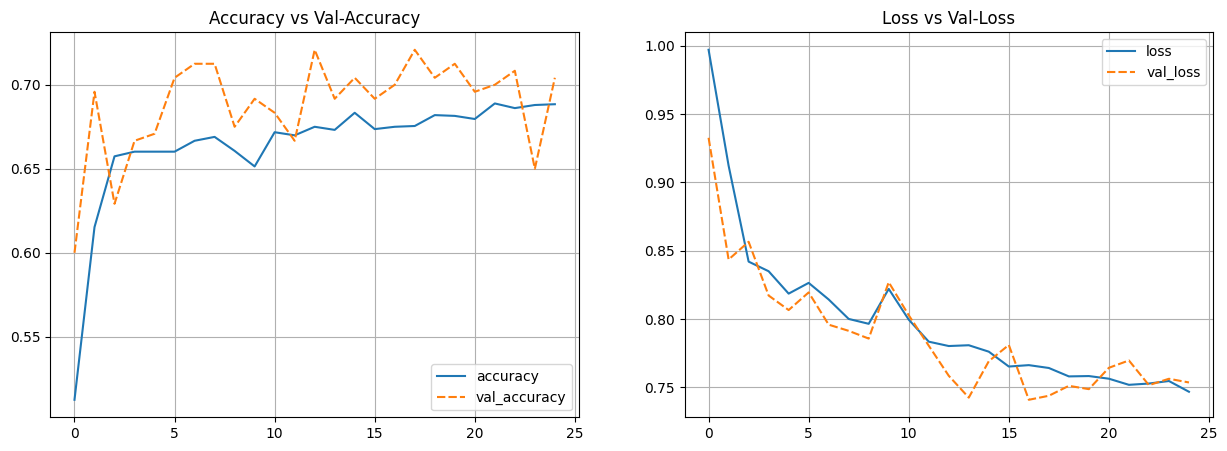

In [ ]:
# Plot Training Results

model_lstm_2_hist_df = pd.DataFrame(model_lstm_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_lstm_2.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       234
           1       0.56      0.06      0.10        88
           2       0.71      0.86      0.78       278

    accuracy                           0.69       600
   macro avg       0.65      0.55      0.53       600
weighted avg       0.67      0.69      0.65       600



After we added transfer learning into our model, the model is less overfit and tends to be good-fit. But, it so hard to increase the accuracy. Here are some possibilities that cause it :

1. Incomplete text preprocessing.
   Dataset from social media often in informal text. Therefore, we must handle it first such as :
   * Implement Word Formalization : `u` become `you`, `gw` become `saya`.
   * Remove repeated characters in a word : `pagiii` become `pagi`, `aduuuhhh` become `aduh`.
   * Handle repeated words : `tinggi2` become `tinggi-tinggi`, `sebenar2nya` become `sebenar-benarnya`.
   * Remove single char.
   * etc.

2. Imbalanced dataset
   
   Our dataset contains of target with distribution :
   * `0` : 2570
   * `1` : 157
   * `2` : 982

# 7 Model Training

## 7.1 LSTM Sequential API

### COBA

In [ ]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

CPU times: user 1.4 s, sys: 7.02 ms, total: 1.41 s
Wall time: 1.46 s


In [ ]:
%%time
model_lstm_1_hist = model_lstm_1.fit(X_train, y_train_ohe, epochs=4, validation_data=(X_val, y_val_ohe))

Epoch 1/4
68/68 [==============================] - 15s 108ms/step - loss: 0.7408 - accuracy: 0.7065 - val_loss: 0.6454 - val_accuracy: 0.7625
Epoch 2/4
68/68 [==============================] - 3s 51ms/step - loss: 0.3658 - accuracy: 0.8750 - val_loss: 0.7342 - val_accuracy: 0.7417
Epoch 3/4
68/68 [==============================] - 3s 42ms/step - loss: 0.2023 - accuracy: 0.9333 - val_loss: 0.8603 - val_accuracy: 0.7000
Epoch 4/4
68/68 [==============================] - 2s 27ms/step - loss: 0.1674 - accuracy: 0.9366 - val_loss: 0.9190 - val_accuracy: 0.7458
CPU times: user 24.2 s, sys: 647 ms, total: 24.9 s
Wall time: 27 s


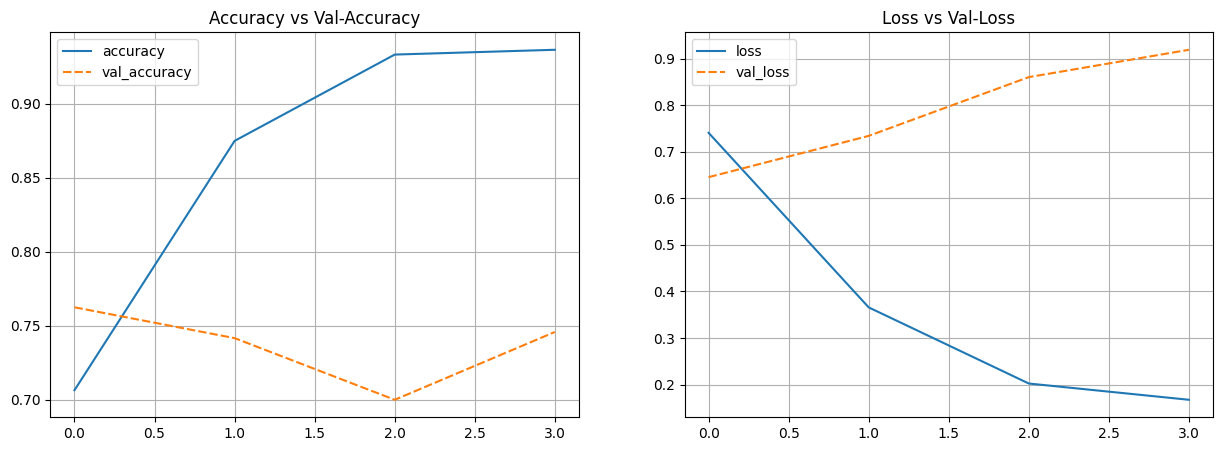

In [ ]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
# new_yticks = np.linspace(0, 2, 10)
# plt.yticks(new_yticks)
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

In [ ]:
# Check the performance of test-set
from sklearn.metrics import classification_report
## Get the probability
y_pred = model_lstm_1.predict_generator(X_test)
test = np.argmax(y_pred,axis=1)

## Display Classification Report
print(classification_report(y_test, test))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       234
           1       0.51      0.23      0.31        88
           2       0.86      0.89      0.87       278

    accuracy                           0.78       600
   macro avg       0.70      0.66      0.66       600
weighted avg       0.76      0.78      0.76       600



It can be seen that our model is overfit. Train accuracy is really high, more than 90 %, meanwhile validation accuracy is around 60 %.